In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'


In [ ]:
all_isc_data = pd.read_excel("isc_aes_data.xlsx", sheet_name="data_values_only")

print(len(all_isc_data))

In [ ]:
#get completed students only
active_completed_students = all_isc_data[(all_isc_data["Status"] == "Active") & (all_isc_data["How much is currently complete"] == 1.00)].reset_index(drop=True)

print(len(active_completed_students))

#fix columns
active_completed_students.columns = [column.strip() for column in active_completed_students.columns]

In [ ]:
#add gain, no change, loss labels
ielts_data = active_completed_students[["Centre", "StudentID", "Entry IELTS Equiv. O", "IELTS Equiv.L", "IELTS Equiv.R", "IELTS Equiv.W", "IELTS Equiv. S", "IELTS eq: Listening", "IELTS eq: Reading", "IELTS eq: Writing", "IELTS eq: Speaking", "IELTS eq: OVERALL", "Lang Gain: Listening", "Lang Gain: Reading", "Lang Gain: Writing", "Lang Gain: Speaking", "Lang Gain: OVERALL"]]

ielts_data.rename({"Entry IELTS Equiv. O": "IELTS_Overall", "IELTS Equiv.L": "IELTS_Listening", "IELTS Equiv.R": "IELTS_Reading", "IELTS Equiv.W": "IELTS_Writing", "IELTS Equiv. S": "IELTS_Speaking", "IELTS eq: Listening": "AES_Listening_IELTS", "IELTS eq: Reading": "AES_Reading_IELTS", "IELTS eq: Writing": "AES_Writing_IELTS", "IELTS eq: Speaking": "AES_Speaking_IELTS", "IELTS eq: OVERALL": "AES_Overall_IELTS"}, axis=1, inplace=True)

#print(ielts_data.columns)

def ielts_status(row):
  if row > 0:
    val = "gain"
  elif row == 0:
    val = "no change"
  else:
    val = "loss"
  return val

ielts_data["Listening_status"] = ielts_data["Lang Gain: Listening"].apply(ielts_status)
ielts_data["Reading_status"] = ielts_data["Lang Gain: Reading"].apply(ielts_status)
ielts_data["Writing_status"] = ielts_data["Lang Gain: Writing"].apply(ielts_status)
ielts_data["Speaking_status"] = ielts_data["Lang Gain: Speaking"].apply(ielts_status)
ielts_data["Overall_status"] = ielts_data["Lang Gain: OVERALL"].apply(ielts_status)




In [ ]:
#fix <4.5
ielts_data.replace({"<4.5": 4.0}, inplace=True)

#fix non-numeric
ielts_data.drop(index=1250, inplace=True)

#fix overall column
ielts_data["IELTS_Overall"] = ielts_data["IELTS_Overall"].astype("float")


In [ ]:
#plot IELTS gain data
palette ={"gain": "#31a354", "no change": "#fec44f", "loss": "#e34a33"}
sns.set_style("darkgrid")


def plot_scatter(skills):
  i = 0
  for skill in skills:
    fig, axs = plt.subplots(1, figsize=(10,6))
    sns.scatterplot(y="AES_{}_IELTS".format(skill), x= "IELTS_{}".format(skill), hue="{}_status".format(skill), data=ielts_data, palette=palette, alpha=0.8)
    axs.set_ylabel("AES {} Grade".format(skill.capitalize()))
    axs.set_xlabel("Pre-Arrival IELTS Grade")
    axs.set_xlim(2.5, 9.5)
    axs.set_ylim(2.5, 9.5)
    axs.set_title("Pre-Arrival IELTS Grade vs Final AES Grade - {}".format(skill.capitalize()))
    axs.legend(title="{} Status".format(skill.capitalize()), loc="lower right")
    plt.tight_layout()
    #plt.savefig("charts/IELTS vs AES - {}".format(skill))
    plt.show()
    i += 1

plot_scatter(["Listening", "Reading", "Writing", "Speaking", "Overall"])

In [ ]:
#get assessment data
assessment_data = active_completed_students[["EX1", "EX3R", "CW1", "EX3W", "CW3", "EX2", "CW2"]].reset_index(drop=True)

assessment_data.replace(0, np.nan, inplace=True)
#assessment_data.fillna(assessment_data.mean(), inplace=True)
assessment_data.dropna(how="any", inplace=True)

corr = assessment_data.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="mako", ax=ax, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title("Heatmap of Assessment Coorelation", fontsize=16, pad=16)


plt.show()

fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(x="EX3R", y="CW1", data=assessment_data, alpha=0.4, label="Reading")
ax.scatter(x="EX3W", y="CW3", data=assessment_data, alpha=0.4, label="Writing")
ax.scatter(x="EX2", y="CW2", data=assessment_data, alpha=0.4, label="Speaking")
ax.set_xlabel("AES Exam Assessment")
ax.set_ylabel("AES Coursework Assessment")
ax.legend()
ax.set_title("Scatterplot of Exam vs Coursework Results by Skill", fontsize=16, pad=16)
plt.show()



#sns.pairplot(assessment_data, plot_kws={"alpha": 0.5})
#plt.show()



In [ ]:
#train linear regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#features
features_array = np.array(assessment_data[["EX3W", "EX1", "EX2", "CW2", "CW1", "EX3R"]])



#labels
labels_array = np.array(assessment_data["CW3"])

#print(features_array.shape, labels_array.shape)

X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.33, random_state=0)



regr = LinearRegression()
#transformer = QuantileTransformer(output_distribution="normal")
#transformer.fit(X_train, y_train)

regr.fit(X_train, y_train)

print(regr.score(X_test, y_test))

predictions = regr.predict(X_test)

df = pd.DataFrame(y_test, columns=["Actual"])
df2 = pd.DataFrame(predictions, columns=["Prediction"])

new_df = df.join(df2)

def status(row):
  if row > 30:
    val = "very poor (over 30% out)"
  elif row > 20:
    val = "poor (20 - 30% out)"
  elif row > 10:
    val = "below expectation (10 - 20% out)"
  elif row > 5:
    val = "satisfactory (5 - 10% out)"
  else:
    val = "excellent (0 - 5% out)"
  return val

new_df["diff"] = abs(new_df["Actual"] - new_df["Prediction"])
new_df["status"] = new_df["diff"].apply(status)

#print(new_df)

#bars

#scatters
fig, axs = plt.subplots(1,2,figsize=(16,6))

palette = {"excellent (0 - 5% out)": "blue", "satisfactory (5 - 10% out)": "green", "below expectation (10 - 20% out)": "orange", "poor (20 - 30% out)": "red", "very poor (over 30% out)": "purple"}

sns.countplot(x="status", data=new_df, palette=palette, order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], ax=axs[0])
axs[0].set_xticklabels(labels=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], rotation=45, ha="right")

sns.scatterplot(x="Actual", y="Prediction", hue="status", data=new_df, palette=palette, ax=axs[1])
plt.legend()
plt.show()

ma_error = mean_absolute_error(y_test, predictions)
rms_error = mean_squared_error(y_test, predictions)
#r2_score = r2_score(y_test, predictions)

print(ma_error, rms_error, r2_score)



In [ ]:
#Random Forest regression
from sklearn.ensemble import RandomForestRegressor

regr_forest = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)

regr_forest.fit(X_train, y_train.ravel())

score = regr_forest.score(X_test, y_test)


predictions = regr_forest.predict(X_test)


df_a_p = pd.DataFrame({"Actual": y_test, "Predicted": predictions, "diff": abs(y_test - predictions)})
df_a_p["status"] = df_a_p["diff"].apply(status)

fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="status", data=df_a_p, ax=axs[0], order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], palette=palette)
axs[0].set_xticklabels(labels=df_a_p.status.unique(), rotation=45, ha="right")
sns.scatterplot(x="Actual", y="Predicted", data=df_a_p, hue="status", ax=axs[1], palette=palette)
plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


regr_gb = GradientBoostingRegressor(random_state=0)
regr_gb.fit(X_train, y_train)

print(regr_gb.score(X_test, y_test.ravel()))


predictions = regr_gb.predict(X_test)

error = mean_absolute_error(y_test, predictions)

print(error)

df3 = pd.DataFrame(y_test, columns=["Actual"])
df4 = pd.DataFrame(predictions, columns=["Predicted"])

gb_df = df3.join(df4)

gb_df


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

kn_regr = KNeighborsRegressor()

kn_regr.fit(X_train, y_train)

predictions_n = kn_regr.predict(X_test)

ma_error_n = mean_absolute_error(y_test, predictions)
rms_error_n = mean_squared_error(y_test, predictions)
r2_score_n = r2_score(y_test, predictions)

#scatter and bar
df_ax_px = pd.DataFrame({"Actual": y_test, "Predicted": predictions_n, "diff": abs(y_test - predictions)})
df_ax_px["status"] = df_a_p["diff"].apply(status)

fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="status", data=df_ax_px, ax=axs[0], order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], palette=palette)
axs[0].set_xticklabels(labels=df_a_p.status.unique(), rotation=45, ha="right")
sns.scatterplot(x="Actual", y="Predicted", data=df_ax_px, hue="status", ax=axs[1], palette=palette)
plt.show()




print(ma_error_n, rms_error_n, r2_score_n)

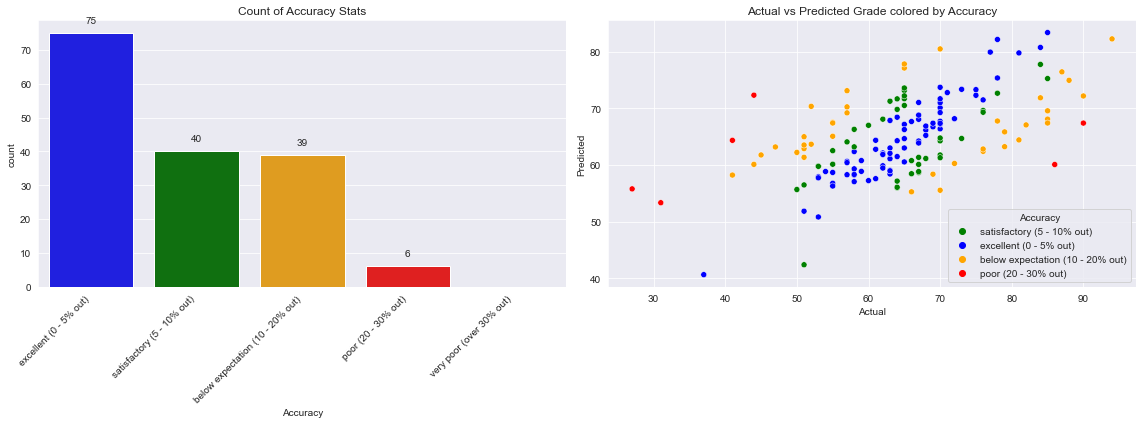

In [245]:
#test with RH data

rh_data = pd.read_excel("../all_student_data.xlsx")

rh_data.replace(0, np.nan, inplace=True)
rh_data.dropna(how="any", inplace=True)

linear_features = np.array(rh_data[["EX1 Listening", "EX2 Speaking", "EX3 Reading", "EX3 Writing", "CW1", "CW2"]])
actual_scores = np.array(rh_data["CW3"])

#liner model
linear_pred = regr.predict(linear_features)

#create df
linear_df = pd.DataFrame({"Full Name": rh_data["Full Name"], "Actual": actual_scores, "Predicted": linear_pred, "Difference": abs(actual_scores - linear_pred)})
linear_df["Accuracy"] = linear_df["Difference"].apply(status)

#plot charts
#scatter and bar
fig, axs = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x="Accuracy", data=linear_df, ax=axs[0], order=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], palette=palette)
axs[0].set_xticklabels(labels=["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"], rotation=45, ha="right")
axs[0].bar_label(axs[0].containers[0], padding=8)
axs[0].set_title("Count of Accuracy Stats")
sns.scatterplot(x="Actual", y="Predicted", data=linear_df, hue="Accuracy", ax=axs[1], palette=palette)
axs[1].set_title("Actual vs Predicted Grade colored by Accuracy")
plt.tight_layout()
plt.savefig("../linear_charts.png")

#create excel doc
writer = pd.ExcelWriter("../cw3_predictions.xlsx", engine="xlsxwriter")
linear_df.to_excel(writer, sheet_name="ML Linear Model", index=False)

workbook = writer.book
worksheet1 = writer.sheets["ML Linear Model"]
worksheet2 = workbook.add_worksheet("Charts")

(max_row_1, max_col_1) = linear_df.shape
column_settings_1 = [{"header": column} for column in linear_df.columns]



worksheet1.add_table(0,0, max_row_1, max_col_1 - 1, {"columns": column_settings_1, "style": "Table Style Light 8"})
worksheet1.set_column(0, max_col_1, 30)

excellent = workbook.add_format({"bg_color": "#3C4EFE", "color": "white", "bold": 1})
sat = workbook.add_format({"bg_color": "#27CB37", "bold": 1})
below_exp = workbook.add_format({"bg_color": "#FFC000", "bold": 1})
poor = workbook.add_format({"bg_color": "#DA0404", "color": "white", "bold": 1})
v_poor = workbook.add_format({"bg_color": "#6E286B", "color": "white", "bold": 1})

formats = [excellent, sat, below_exp, poor, v_poor]
i = 0

for entry in ["excellent (0 - 5% out)", "satisfactory (5 - 10% out)", "below expectation (10 - 20% out)", "poor (20 - 30% out)", "very poor (over 30% out)"]:
  worksheet1.conditional_format("E2:E{}".format(max_row_1 + 1), {'type': 'cell', 'criteria': 'equal to', 'value': '"{}"'.format(entry), 'format': formats[i]})
  i += 1

worksheet2.insert_image("A2", '../linear_charts.png')

writer.save()